In [1]:
import keras

# load image datasets from the CIFAR-10 database
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
)
X_test = X_test.reshape(
    (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
)

y_train = y_train[:, 0]
y_test = y_test[:, 0]

In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

def experiment():
    rf_l = []
    dt_l = []
    sdt_l = []
    
    for i in range(5):

        rf = RandomForestClassifier()
        rf.fit(X_r[:(i+1)*10000],y_r[:(i+1)*10000])
        rf_l.append(prediction(rf))

        dt = DecisionTreeClassifier()
        dt.fit(X_r[:(i+1)*10000],y_r[:(i+1)*10000])
        dt_l.append(prediction(dt))

        sdt = DecisionTreeClassifier()
        not_first = False
        for j in range(i+1):
            sdt.fit(X_r[j*10000:(j+1)*10000],y_r[j*10000:(j+1)*10000], update_tree=not_first)
            not_first = True
        sdt_l.append(prediction(sdt))
    
    p_l = []
    p_l.append(rf_l)
    p_l.append(dt_l)
    p_l.append(sdt_l)
    
    return p_l

In [3]:
def prediction(classifier):
    predictions = classifier.predict(X_test)

    p_t = 0
    for i in range(X_test.shape[0]):
        if predictions[i]==y_test[i]:
            p_t+=1

    return p_t/X_test.shape[0]

In [ ]:
from numpy.random import permutation

results = []

for i in range(10):
    p = permutation(X_train.shape[0])

    X_r = X_train[p]
    y_r = y_train[p]
    
    results.append(experiment())

In [ ]:
import numpy as np

means = np.mean(results, axis=0)

rf_mean = means[0]
dt_mean = means[1]
sdt_mean = means[2]

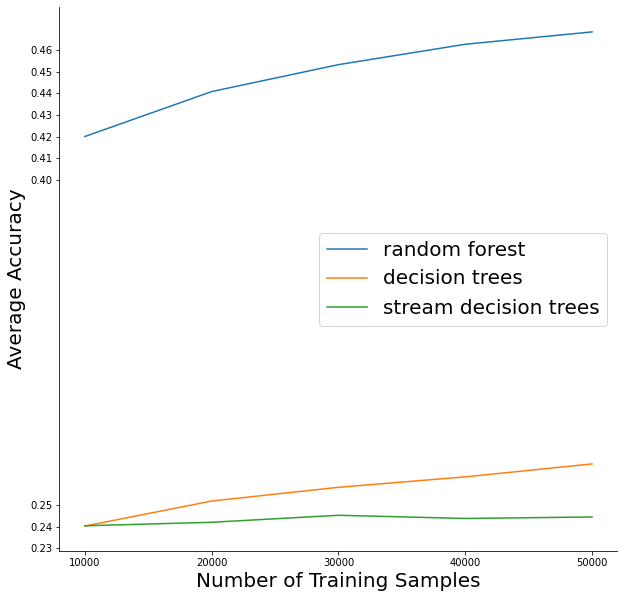

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

n_train = range(10000, 60000, 10000)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize = 20)
ax.set_ylabel("Average Accuracy", fontsize = 20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([10000, 20000, 30000, 40000, 50000])
ax.set_yticks([0.22,0.23,0.24,0.25,0.4,0.41,0.42,0.43,0.44,0.45,0.46])

plt.plot(n_train, rf_mean, label="random forest")
plt.plot(n_train, dt_mean, label="decision trees")
plt.plot(n_train, sdt_mean, label="stream decision trees")
plt.legend(fontsize = 20)

In [2]:
from numpy.random import permutation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from spdt import NaiveStreamForest, CascadeStreamForest

def experiment_small():
    rf_l = []
    dt_l = []
    sdt_l = []
    nsf_l = []
    csf_l = []

    rf = RandomForestClassifier()
    dt = DecisionTreeClassifier()
    sdt = DecisionTreeClassifier()
    nsf = NaiveStreamForest()
    csf = CascadeStreamForest()

    for i in range(500):

        rf.fit(X_r[:(i+1)*100],y_r[:(i+1)*100])
        rf_l.append(prediction(rf))

        dt.fit(X_r[:(i+1)*100],y_r[:(i+1)*100])
        dt_l.append(prediction(dt))

        X_t = X_r[i*100:(i+1)*100]
        y_t = y_r[i*100:(i+1)*100]

        sdt.partial_fit(X_t, y_t)
        sdt_l.append(prediction(sdt))
        
        nsf.fit(X_t, y_t)
        nsf_l.append(prediction(nsf))
        
        csf.fit(X_t, y_t)
        csf_l.append(prediction(csf))
    
    p_l = []
    p_l.append(rf_l)
    p_l.append(dt_l)
    p_l.append(sdt_l)
    p_l.append(nsf_l)
    p_l.append(csf_l)

    return p_l

In [3]:
def prediction(classifier):
    predictions = classifier.predict(X_test)

    p_t = 0
    for i in range(X_test.shape[0]):
        if predictions[i]==y_test[i]:
            p_t+=1

    return p_t/X_test.shape[0]

In [ ]:
results = []

for i in range(100):
    p = permutation(X_train.shape[0])
    
    X_r = X_train[p]
    y_r = y_train[p]
    results.append(experiment_small())

In [9]:
import numpy as np

means = np.mean(results, axis=0)

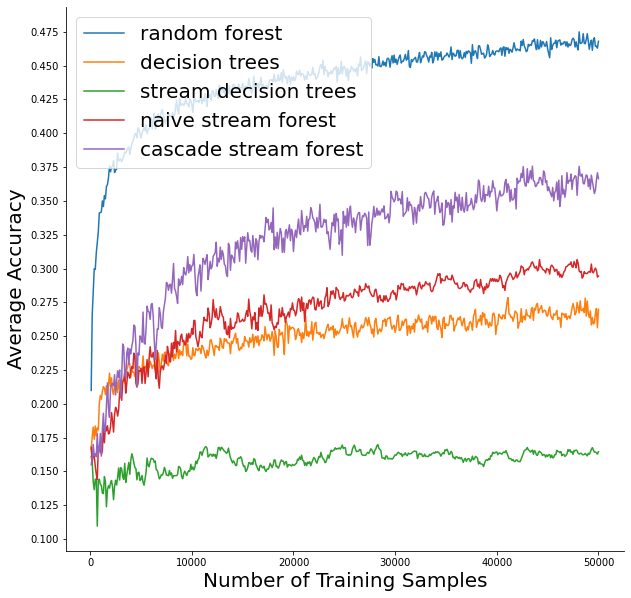

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

n_train = range(100, 50100, 100)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("Number of Training Samples", fontsize = 20)
ax.set_ylabel("Average Accuracy", fontsize = 20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks(np.arange(0.1, 0.5, step=0.025))

plt.plot(n_train, means[0], label="random forest")
plt.plot(n_train, means[1], label="decision trees")
plt.plot(n_train, means[2], label="stream decision trees")
plt.plot(n_train, means[3], label="naive stream forest")
plt.plot(n_train, means[4], label="cascade stream forest")
plt.legend(fontsize = 20)